In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from myutils.nerdssData import nerdssData
from myutils.process_AD import readResT_from_NERDSS

In [3]:
def readGillespieSurvP(filename):
    with open(filename) as f:
        reading = False
        times = []
        survP = []
        numDiss = 'Not Read'
        for line in f:
            if line.strip() == '# START SURVIVAL PROB':
                reading = True
            elif line.strip() == '# END SURVIVAL PROB':
                reading = False
            elif line.strip() == '# Mean Residence Time':
                meanResT = float(f.readline().strip())
            elif line.strip().startswith('Number of dissociation events:'):
                numDiss = int(line.split(':')[1])
            else:
                if reading:
                    linelist = line.split()
                    times.append(float(linelist[0]))
                    survP.append(float(linelist[1]))
    return np.array(times), np.array(survP), meanResT, numDiss

def get_survival_prob(resident_times, bins=100):

    # get survival probabilities
    h = np.histogram(resident_times, bins=bins, density=True)
    return h[1], np.append([1], 1 - np.cumsum(h[0]*np.diff(h[1])))

In [4]:
pfolder_NERDSS = './Simulations/NERDSS_monomer/'
pfolder_Gillespie = './Simulations/NERDSS_monomer/Gillespie/'

In [5]:
def compareNerdssWithGillespie(dt, folders, NerdssRepeatIDs, startT=10, binwidth=0.05, timeUpperLimit=1000):
    for j, pfolder in enumerate(folders):
        gllspFile = pfolder_Gillespie+f'/out_{j}_r0'
        timeGllsp, survPGllsp, meanRestGllsp, numEvents = readGillespieSurvP(gllspFile)
        resTime_nerdss = []
        resTime_means = []
        lastTime = []
        for i in NerdssRepeatIDs:
            jobfolder = pfolder_NERDSS+f'/{pfolder}/SIMS/{i}/'
            resTi, _ = readResT_from_NERDSS(
                jobfolder+'/DATA/assoc_dissoc_time.dat', dt, startT=startT
            )
            resTime_nerdss.append(resTi)
            resTime_means.append(np.mean(resTi))
            lastTime_i = 0
            with open(jobfolder+'/DATA/histogram_complexes_time.dat') as f:
                for line in f:
                    if line.strip().startswith('Time (s)'):
                        lastTime_i = float(line.split(':')[1])
            lastTime.append(lastTime_i)

        print('Gillespie: %.2f'%meanRestGllsp)
        print('nerdss: %.2f +- %.2f'%(np.mean(resTime_means), np.std(resTime_means)))


        time, survP = get_survival_prob(np.concatenate(resTime_nerdss), np.arange(0, timeUpperLimit, binwidth))
        plt.plot(time[survP>1e-3], survP[survP>1e-3], lw=1, label='NERDSS', alpha=0.5)
            
        plt.plot(
            timeGllsp[survPGllsp>1e-3], survPGllsp[survPGllsp>1e-3], 
            label='Gillespie', color='black'
        )
        plt.xlim([0, np.max(timeGllsp[survPGllsp>1e-3])])
        plt.semilogy()
        plt.show()

Gillespie: 0.83
nerdss: 0.83 +- 0.03


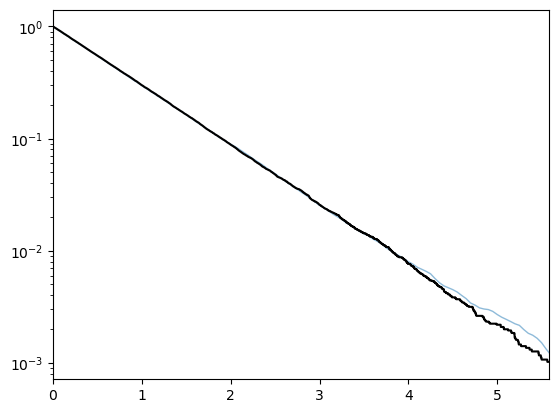

Gillespie: 0.89
nerdss: 0.87 +- 0.04


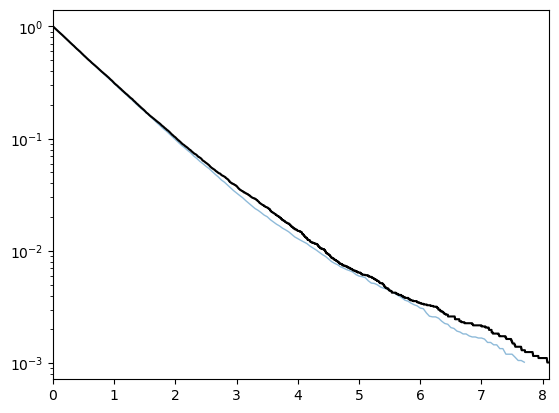

Gillespie: 1.21
nerdss: 1.17 +- 0.08


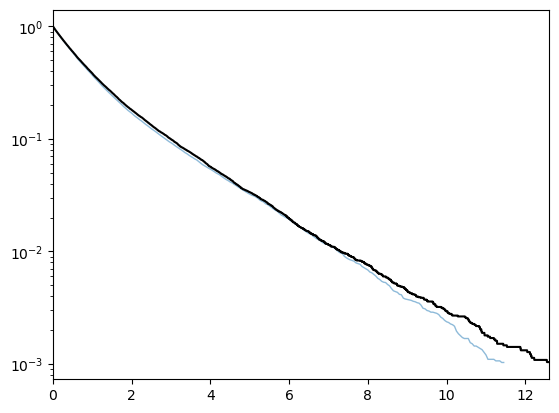

Gillespie: 2.28
nerdss: 2.28 +- 0.14


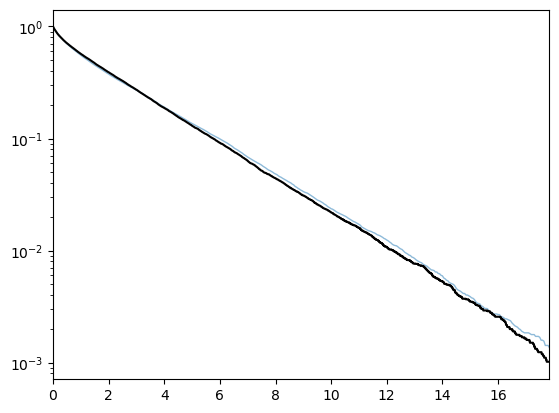

In [7]:
foldersNerdss = ['kpp0', 'kppE2',  'kppE3', 'kppE4']
NerdssRepeatIDs = [i for i in range(1,49)]
compareNerdssWithGillespie(1e-6, foldersNerdss, NerdssRepeatIDs, startT=30)

In [8]:
NerdssRepeatIDs = [i for i in range(1,49)]
nerdss = nerdssData(NerdssRepeatIDs, pfolder_NERDSS+'/kppE4/SIMS')
nerdss.readHist(dataHist='DATA/histogram_complexes_time.dat', ifprint=False)
print(nerdss.MOLNAMES, nerdss.time[-1])

>>>>>> parsing ./Simulations/NERDSS_monomer//kppE4/SIMS
WaterBox = [1050.0, 31.623, 31.623] # VtoL=4000
{'P': 20, 'N': 600}
Reactions:
N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
P(dmr) + P(dmr) <-> P(dmr!1).P(dmr!1)
<<<<<< finished parsing
------------------------------------------------------
['P: 2. N: 2.', 'N: 1.', 'P: 2. N: 1.', 'P: 1.', 'P: 2.', 'P: 1. N: 1.'] 332.0


Text(0.5, 1.0, 'KPP=$10^4$ $M^{-1}$')

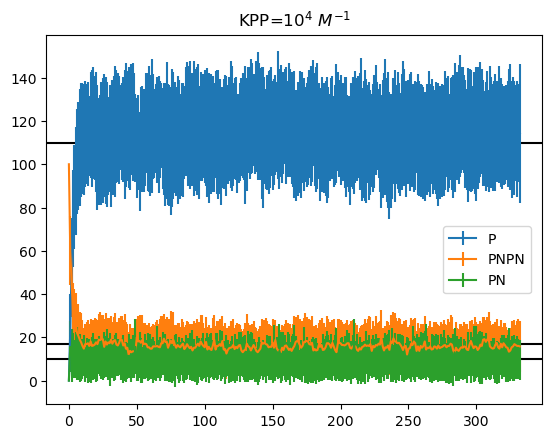

In [9]:
scale = 10 # compare NERDSS with Gillespie simulation
plt.axhline(110, color='black')
plt.errorbar(
    nerdss.time, 
    nerdss.MOLS['P: 1.']*scale,
    (nerdss.MOLS_err['P: 1.'])*scale,
    label='P',
)
plt.axhline(17, color='black')
plt.errorbar(
    nerdss.time, 
    nerdss.MOLS['P: 2. N: 2.']*scale,
    (nerdss.MOLS_err['P: 2. N: 2.'])*scale,
    label='PNPN',
)
plt.axhline(10, color='black')
plt.errorbar(
    nerdss.time, 
    nerdss.MOLS['P: 1. N: 1.']*scale,
    (nerdss.MOLS_err['P: 1. N: 1.'])*scale,
    label='PN',
)
plt.legend(loc=[0.8,0.3])
plt.title('KPP=$10^4$ $M^{-1}$')